In [6]:
# recommendation.py
import pandas as pd
import ast
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter

# 🔧 Enhanced ingredient normalization
def normalize_ingredient(ingredient):
    ingredient = ingredient.lower().strip()
    ingredient = re.sub(r'[^\w\s]', '', ingredient)  # remove punctuation
    ingredient = re.sub(r'\s+', ' ', ingredient)     # normalize spaces
    
    # Better singularization with common plural endings
    plural_endings = {
        's': '',
        'es': 'e',
        'ies': 'y'
    }
    for ending, replacement in plural_endings.items():
        if ingredient.endswith(ending) and len(ingredient) > len(ending):
            ingredient = ingredient[:-len(ending)] + replacement
            break
            
    # Common ingredient substitutions
    substitutions = {
        'tomato': 'tomatoes',
        'potato': 'potatoes',
        'leaf': 'leaves'
    }
    return substitutions.get(ingredient, ingredient)

# 📦 Enhanced data loading with TF-IDF
def load_data():
    try:
        df = pd.read_csv("Food Ingredients and Recipe Dataset with Image Name Mapping.csv")
        df = df[['Title', 'Cleaned_Ingredients', 'Instructions']].dropna()
        
        # Convert ingredient strings to lists
        df['Cleaned_Ingredients'] = df['Cleaned_Ingredients'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
        
        # Normalize ingredients
        df['Cleaned_Ingredients'] = df['Cleaned_Ingredients'].apply(
            lambda ings: [normalize_ingredient(ing) for ing in ings if ing.strip()])
        
        # Create TF-IDF vectorizer
        df['ingredients_str'] = df['Cleaned_Ingredients'].apply(lambda x: ' '.join(x))
        global vectorizer, tfidf_matrix
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
        tfidf_matrix = vectorizer.fit_transform(df['ingredients_str'])
        
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame(columns=['Title', 'Cleaned_Ingredients', 'Instructions'])

# 🧮 Enhanced similarity scoring
def calculate_scores(user_ingredients, df):
    # TF-IDF cosine similarity
    user_input_str = ' '.join(user_ingredients)
    user_vec = vectorizer.transform([user_input_str])
    tfidf_scores = cosine_similarity(user_vec, tfidf_matrix).flatten()
    
    # Jaccard similarity
    jaccard_scores = []
    user_set = set(user_ingredients)
    for ings in df['Cleaned_Ingredients']:
        recipe_set = set(ings)
        intersection = user_set & recipe_set
        union = user_set | recipe_set
        jaccard_scores.append(len(intersection) / len(union) if union else 0)
    
    # Ingredient coverage score
    coverage_scores = []
    for ings in df['Cleaned_Ingredients']:
        recipe_set = set(ings)
        common = user_set & recipe_set
        coverage_scores.append(len(common) / len(recipe_set) if recipe_set else 0)
    
    # Combine scores with weights
    combined_scores = (
        0.5 * tfidf_scores + 
        0.3 * np.array(jaccard_scores) + 
        0.2 * np.array(coverage_scores)
    )
    
    return combined_scores

# 🍽 Enhanced recommendation function
def recommend_recipes(user_input, df, top_n=10):
    try:
        user_ingredients = [normalize_ingredient(i) for i in user_input.split(",") if i.strip()]
        if not user_ingredients:
            return []
            
        scores = calculate_scores(user_ingredients, df)
        
        results = []
        for idx in (-scores).argsort()[:top_n if top_n else len(scores)]:
            if scores[idx] > 0:  # Only include recipes with some match
                results.append((
                    df.iloc[idx]['Title'],
                    scores[idx],
                    df.iloc[idx]['Cleaned_Ingredients'],
                    df.iloc[idx]['Instructions']
                ))
        
        return results
    except Exception as e:
        print(f"Error in recommendation: {e}")
        return []

# In[2]:







In [4]:
!jupyter nbconvert --to python recommendation.ipynb

[NbConvertApp] Converting notebook recommendation.ipynb to python
[NbConvertApp] Writing 2227 bytes to recommendation.py


In [2]:
import pandas as pd
import ast
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

%matplotlib inline 


In [3]:
def normalize_ingredient(ingredient):
    ingredient = ingredient.lower().strip()
    ingredient = re.sub(r'[^\w\s]', '', ingredient)
    ingredient = re.sub(r'\s+', ' ', ingredient)
    
    plural_endings = {'ies': 'y', 'es': 'e', 's': ''}
    for ending, replacement in plural_endings.items():
        if ingredient.endswith(ending) and len(ingredient) > len(ending):
            ingredient = ingredient[:-len(ending)] + replacement
            break
            
    substitutions = {'tomato': 'tomatoes', 'potato': 'potatoes', 'leaf': 'leaves'}
    return substitutions.get(ingredient, ingredient)

def load_data():
    try:
        df = pd.read_csv("Food Ingredients and Recipe Dataset with Image Name Mapping.csv")
        df = df[['Title', 'Cleaned_Ingredients', 'Instructions']].dropna()
        df['Cleaned_Ingredients'] = df['Cleaned_Ingredients'].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
        df['Cleaned_Ingredients'] = df['Cleaned_Ingredients'].apply(
            lambda ings: [normalize_ingredient(ing) for ing in ings if ing.strip()])
        df['ingredients_str'] = df['Cleaned_Ingredients'].apply(lambda x: ' '.join(x))
        global vectorizer, tfidf_matrix
        vectorizer = TfidfVectorizer(tokenizer=lambda x: x.split(), lowercase=False)
        tfidf_matrix = vectorizer.fit_transform(df['ingredients_str'])
        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return pd.DataFrame(columns=['Title', 'Cleaned_Ingredients', 'Instructions'])

def calculate_scores(user_ingredients, df):
    user_input_str = ' '.join(user_ingredients)
    user_vec = vectorizer.transform([user_input_str])
    tfidf_scores = cosine_similarity(user_vec, tfidf_matrix).flatten()
    
    jaccard_scores = []
    user_set = set(user_ingredients)
    for ings in df['Cleaned_Ingredients']:
        recipe_set = set(ings)
        intersection = user_set & recipe_set
        union = user_set | recipe_set
        jaccard_scores.append(len(intersection) / len(union) if union else 0)
    
    coverage_scores = []
    for ings in df['Cleaned_Ingredients']:
        recipe_set = set(ings)
        common = user_set & recipe_set
        coverage_scores.append(len(common) / len(recipe_set) if recipe_set else 0)
    
    combined_scores = (
        0.5 * tfidf_scores + 
        0.3 * np.array(jaccard_scores) + 
        0.2 * np.array(coverage_scores)
    )
    
    return combined_scores

def recommend_recipes(user_input, df, top_n=10):
    try:
        user_ingredients = [normalize_ingredient(i) for i in user_input.split(",") if i.strip()]
        if not user_ingredients:
            return []
            
        scores = calculate_scores(user_ingredients, df)
        results = []
        for idx in (-scores).argsort()[:top_n]:
            if scores[idx] > 0:
                results.append((
                    df.iloc[idx]['Title'],
                    scores[idx],
                    df.iloc[idx]['Cleaned_Ingredients'],
                    df.iloc[idx]['Instructions']
                ))
        return results
    except Exception as e:
        print(f"Error in recommendation: {e}")
        return []

def evaluate_precision_at_k(df, k=5, sample_size=100):
    correct = 0
    total = 0
    for _, row in df.sample(min(sample_size, len(df))).iterrows():
        full_ingredients = row['Cleaned_Ingredients']
        if len(full_ingredients) < 4:
            continue
        test_ingredients = full_ingredients[:len(full_ingredients)//2]
        held_out = set(full_ingredients[len(full_ingredients)//2:])
        recommendations = recommend_recipes(','.join(test_ingredients), df, top_n=k)
        recommended_ings = set([ing for r in recommendations for ing in r[2]])
        if recommended_ings:
            correct += len(held_out & recommended_ings)
            total += len(held_out)
    precision = correct / total if total > 0 else 0
    print(f"Precision@{k}: {precision:.4f}")
    return precision

def plot_score_distribution(user_input, df):
    user_ingredients = [normalize_ingredient(i) for i in user_input.split(",") if i.strip()]
    scores = calculate_scores(user_ingredients, df)
    plt.figure(figsize=(10, 5))
    plt.hist(scores, bins=50, color='skyblue', edgecolor='black')
    plt.title("Distribution of Similarity Scores")
    plt.xlabel("Score")
    plt.ylabel("Number of Recipes")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_common_ingredients(df, top_n=20):
    ingredient_counts = Counter([ing for sublist in df['Cleaned_Ingredients'] for ing in sublist])
    common = ingredient_counts.most_common(top_n)
    ingredients, counts = zip(*common)
    plt.figure(figsize=(12, 5))
    plt.bar(ingredients, counts, color='coral')
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Top {top_n} Most Common Ingredients")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [4]:
df = load_data()
df.head()


C:\Users\Kanav\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,Title,Cleaned_Ingredients,Instructions,ingredients_str
0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[1 3½4lb whole chicken, 2¾ tsp kosher salt div...","Pat chicken dry with paper towels, season all ...",1 3½4lb whole chicken 2¾ tsp kosher salt divid...
1,Crispy Salt and Pepper Potatoes,"[2 large egg white, 1 pound new potatoes about...",Preheat oven to 400°F and line a rimmed baking...,2 large egg white 1 pound new potatoes about 1...
2,Thanksgiving Mac and Cheese,"[1 cup evaporated milk, 1 cup whole milk, 1 ts...",Place a rack in middle of oven; preheat to 400...,1 cup evaporated milk 1 cup whole milk 1 tsp g...
3,Italian Sausage and Bread Stuffing,[1 ¾ to 1pound round italian loaf cut into 1in...,Preheat oven to 350°F with rack in middle. Gen...,1 ¾ to 1pound round italian loaf cut into 1inc...
4,Newton's Law,"[1 teaspoon dark brown sugar, 1 teaspoon hot w...",Stir together brown sugar and hot water in a c...,1 teaspoon dark brown sugar 1 teaspoon hot wat...


In [5]:
user_input = "onion, tomato, garlic"
recommendations = recommend_recipes(user_input, df, top_n=5)

for i, (title, score, ings, _) in enumerate(recommendations, 1):
    print(f"{i}. {title} (Score: {score:.2f}) - Ingredients: {ings}")


1. My Mother's Butter, Tomato, and Onion Sauce (Score: 0.21) - Ingredients: ['2 pounds ripe tomatoes or 3 cups canned whole peeled tomatoes with their juice', '1 medium sweet yellow onion', '5 tablespoons butter', '1 14 teaspoons salt']
2. Bacon, Lettuce, and Cherry Tomato Salad with Aioli Dressing (Score: 0.17) - Ingredients: ['5 ounces applewoodsmoked bacon about 6 slice', '12 cups torn romaine lettuce from 1 large head about 13 ounce', '8 ounces cherry tomatoes grape tomatoes andor pear tomatoes halved', '1 garlic clove pressed', '3 tablespoons mayonnaise', '1 12 tablespoons whitewine vinegar']
3. Tomato Olive Caper Compote (Score: 0.17) - Ingredients: ['1 teaspoon oil', '1 small onion diced', '1 clove garlic minced', '4 medium tomatoes roughly chopped', '14 cup black olives quartered', '1 tablespoons caper', '12 teaspoon salt']
4. Slow-Roasted Tomatoes (Score: 0.16) - Ingredients: ['4 pounds plum tomatoes halved lengthwise', '6 garlic cloves minced', '5 tablespoons extravirgin oliv

In [6]:
evaluate_precision_at_k(df)


Precision@5: 1.0000


1.0

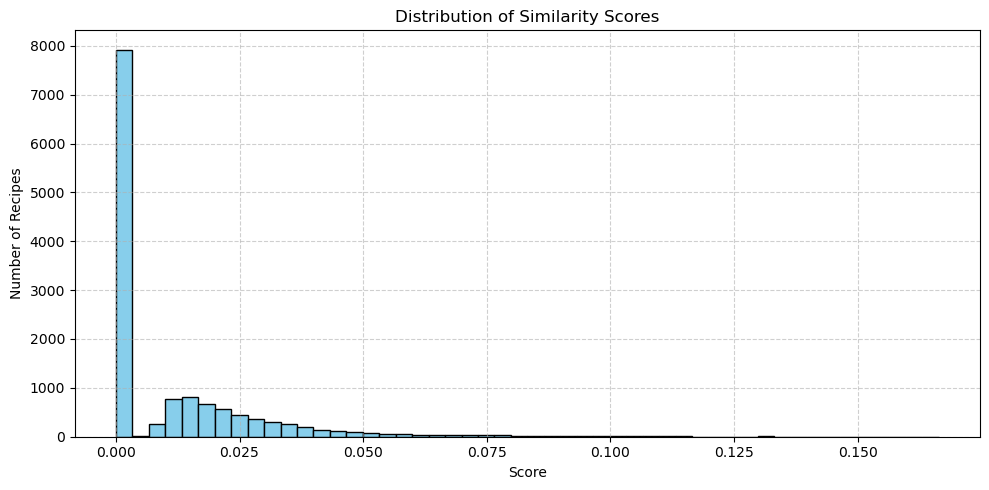

In [7]:
plot_score_distribution("onion, garlic, potato", df)


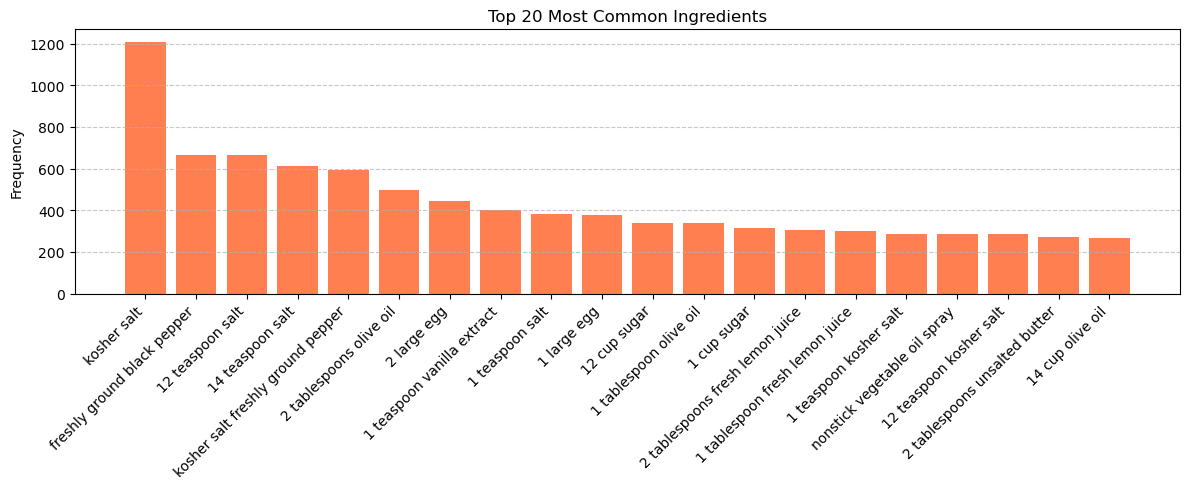

In [8]:
plot_common_ingredients(df)
